In [1]:
!git clone https://github.com/coastalcph/mpararel

Cloning into 'mpararel'...
remote: Enumerating objects: 60154, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 60154 (delta 0), reused 1 (delta 0), pack-reused 60147
Receiving objects: 100% (60154/60154), 64.53 MiB | 19.41 MiB/s, done.
Resolving deltas: 100% (46008/46008), done.
Updating files: 100% (22417/22417), done.


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.6 MB/s eta 0:00:00


In [3]:
%cd /content/mpararel/data/mpararel_reviewed

/content/mpararel/data/mpararel_reviewed


In [1]:
import json
import os
from os import listdir
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

In [5]:
from transformers import AutoTokenizer, pipeline

tokenizer = AutoTokenizer.from_pretrained(
                'xlm-roberta-base',
                revision='main')

fill_mask = pipeline(task='fill-mask',
         tokenizer=tokenizer,
         model = 'xlm-roberta-base',
         revision = 'main')

In [6]:
def make_masks(pattern, lang):
    pat = pd.read_json(path_or_buf=f'patterns/{lang}/{pattern}', lines=True)
    tup = pd.read_json(path_or_buf=f'tuples/{lang}/{pattern}', lines=True)
    pat['pattern'] = pat['pattern'].apply(lambda x: x.replace('’', '\'').replace('—', '-'))
    pat['key'] = 0
    tup['key'] = 0
    res = pat.reset_index().merge(tup.reset_index(), on='key', how='outer')\
        [['index_x', 'pattern', 'index_y', 'sub_label', 'sub_uri', 'obj_label', 'obj_uri', 'lineid']]\
        .rename(columns={'index_x':'pattern_ind', 'index_y':'tuple_ind'}, inplace=False)
    res['masked'] = res.apply(lambda x: x.pattern.replace('[X]', x.sub_label).replace('[Y]', '<mask>'), axis=1)
    return res

def infer(data, filename):
    data['res'] = data['masked'].progress_apply(fill_mask)
    data2 = data.explode('res', ignore_index=True)
    data2['pred_token'] = data2['res'].apply(lambda x: x['token_str'])
    data2['pred_score'] = data2['res'].apply(lambda x: x['score'])
    data2.to_csv(filename)
    return data2

In [7]:
pattern = 'P36.jsonl'
infer(make_masks(pattern, 'ru'), 'res_ru.csv')

100%|██████████| 9016/9016 [52:17<00:00,  2.87it/s]


,pattern_ind,pattern,tuple_ind,sub_label,sub_uri,obj_label,obj_uri,lineid,masked,res,pred_token,pred_score
0,0,[Y] является столицей [X],0,Азербайджан,Q227,Баку,Q9248,0,<mask> является столицей Азербайджан,"{'score': 0.3360705077648163, 'token': 190108,...",Азербайджан,0.336071
1,0,[Y] является столицей [X],0,Азербайджан,Q227,Баку,Q9248,0,<mask> является столицей Азербайджан,"{'score': 0.07764634490013123, 'token': 239735...",Армения,0.077646
2,0,[Y] является столицей [X],0,Азербайджан,Q227,Баку,Q9248,0,<mask> является столицей Азербайджан,"{'score': 0.06343525648117065, 'token': 12786,...",Она,0.063435
3,0,[Y] является столицей [X],0,Азербайджан,Q227,Баку,Q9248,0,<mask> является столицей Азербайджан,"{'score': 0.05813024565577507, 'token': 414, '...",что,0.058130
4,0,[Y] является столицей [X],0,Азербайджан,Q227,Баку,Q9248,0,<mask> является столицей Азербайджан,"{'score': 0.04669239744544029, 'token': 12382,...",Что,0.046692
...,...,...,...,...,...,...,...,...,...,...,...,...
45075,13,"[X], который имеет заглавную букву [Y]",643,Фландрия,Q234,Брюссель,Q239,702,"Фландрия, который имеет заглавную букву <mask>","{'score': 0.18979355692863464, 'token': 2, 'to...",</s>,0.189794
45076,13,"[X], который имеет заглавную букву [Y]",643,Фландрия,Q234,Брюссель,Q239,702,"Фландрия, который имеет заглавную букву <mask>","{'score': 0.04931796342134476, 'token': 563, '...",F,0.049318
45077,13,"[X], который имеет заглавную букву [Y]",643,Фландрия,Q234,Брюссель,Q239,702,"Фландрия, который имеет заглавную букву <mask>","{'score': 0.0424635224044323, 'token': 5, 'tok...",.,0.042464
45078,13,"[X], который имеет заглавную букву [Y]",643,Фландрия,Q234,Брюссель,Q239,702,"Фландрия, который имеет заглавную букву <mask>","{'score': 0.028230424970388412, 'token': 12, '...",:,0.028230


In [8]:
infer(make_masks(pattern, 'fr'), 'res_fr.csv')

100%|██████████| 7678/7678 [47:17<00:00,  2.71it/s]


,pattern_ind,pattern,tuple_ind,sub_label,sub_uri,obj_label,obj_uri,lineid,masked,res,pred_token,pred_score
0,0,"la capitale de [X], [Y]",0,Azerbaïdjan,Q227,Bakou,Q9248,0,"la capitale de Azerbaïdjan, <mask>","{'score': 0.47365307807922363, 'token': 2, 'to...",</s>,0.473653
1,0,"la capitale de [X], [Y]",0,Azerbaïdjan,Q227,Bakou,Q9248,0,"la capitale de Azerbaïdjan, <mask>","{'score': 0.020715342834591866, 'token': 5, 't...",.,0.020715
2,0,"la capitale de [X], [Y]",0,Azerbaïdjan,Q227,Bakou,Q9248,0,"la capitale de Azerbaïdjan, <mask>","{'score': 0.019502175971865654, 'token': 8, 't...",de,0.019502
3,0,"la capitale de [X], [Y]",0,Azerbaïdjan,Q227,Bakou,Q9248,0,"la capitale de Azerbaïdjan, <mask>","{'score': 0.017762286588549614, 'token': 21, '...",la,0.017762
4,0,"la capitale de [X], [Y]",0,Azerbaïdjan,Q227,Bakou,Q9248,0,"la capitale de Azerbaïdjan, <mask>","{'score': 0.012882580980658531, 'token': 27, '...",...,0.012883
...,...,...,...,...,...,...,...,...,...,...,...,...
38385,10,[Y] est la capitale de [X],697,Flandre,Q234,Bruxelles,Q239,702,<mask> est la capitale de Flandre,"{'score': 0.11680684983730316, 'token': 14663,...",Elle,0.116807
38386,10,[Y] est la capitale de [X],697,Flandre,Q234,Bruxelles,Q239,702,<mask> est la capitale de Flandre,"{'score': 0.08899188786745071, 'token': 164298...",Bordeaux,0.088992
38387,10,[Y] est la capitale de [X],697,Flandre,Q234,Bruxelles,Q239,702,<mask> est la capitale de Flandre,"{'score': 0.07053951174020767, 'token': 7644, ...",Qui,0.070540
38388,10,[Y] est la capitale de [X],697,Flandre,Q234,Bruxelles,Q239,702,<mask> est la capitale de Flandre,"{'score': 0.06336981058120728, 'token': 124532...",Ceci,0.063370


In [7]:
%cd /content

/content


### Доля правильно заполненных пропусков
Для каждой пары паттерн-тупл посмотрим, предложила ли модель правильный ответ среди топ-5 ответов, посчитаем долю таких пар.

In [3]:
ru = pd.read_csv('res_ru.csv', index_col=0)
fr = pd.read_csv('res_fr.csv', index_col=0)
ru.head(2)

,pattern_ind,pattern,tuple_ind,sub_label,sub_uri,obj_label,obj_uri,lineid,masked,res,pred_token,pred_score
0,0,[Y] является столицей [X],0,Азербайджан,Q227,Баку,Q9248,0,<mask> является столицей Азербайджан,"{'score': 0.3360705077648163, 'token': 190108,...",Азербайджан,0.336071
1,0,[Y] является столицей [X],0,Азербайджан,Q227,Баку,Q9248,0,<mask> является столицей Азербайджан,"{'score': 0.07764634490013123, 'token': 239735...",Армения,0.077646


In [4]:
# get the share of pairs pattern-tuple, where among top-5 answers there is a correct one
corrects_ru = ru.groupby(['pattern_ind', 'tuple_ind', 'pattern', 'sub_label', 'obj_label'])['pred_token'].apply(list).reset_index()\
            .apply(lambda x: any(y==x['obj_label'] for y in x['pred_token']), axis=1)
corrects_ru.sum()/corrects_ru.count()

0.06089174800354925

In [5]:
corrects_fr = fr.groupby(['pattern_ind', 'tuple_ind', 'pattern', 'sub_label', 'obj_label'])['pred_token'].apply(list).reset_index()\
            .apply(lambda x: any(y==x['obj_label'] for y in x['pred_token']), axis=1)
corrects_fr.sum()/corrects_fr.count()

0.07671268559520708

Видно, что она маленькая: для французского 8%, а для русского вообще 6%. Посмотрим, в чем дело - посмотрим, какие паттерны мы заполнили лучше и хуже всего:

In [6]:
corrects_ru_set = ru.groupby(['pattern_ind', 'tuple_ind', 'pattern', 'sub_label', 'obj_label'])['pred_token'].apply(list).reset_index()[corrects_ru]
corrects_ru_set.groupby(['pattern'])['pred_token'].count().sort_values(ascending=False)

pattern
столица [X] - [Y]                         126
[Y] - столица [X]                          70
[Y], столица [X]                           64
[Y], это столица [X]                       59
[X] столица, [Y]                           56
[Y] является столицей [X]                  52
[Y], то есть столица [X]                   49
[X], который имеет столицу [Y]             21
[X], который имеет заглавную букву [Y]     12
заглавная буква [X] - [Y]                  11
капитал [X], [Y]                           11
капитал [X] - [Y]                          10
столица [X] [Y]                             8
Name: pred_token, dtype: int64

In [7]:
ru_bad = [1, 2, 7, 8, 9, 11, 13, 10]
ru[['pattern_ind', 'pattern']].drop_duplicates()
# плохие индексы - 1, 2, 7, 8, 9, 11, 13; 10 повторяется

,pattern_ind,pattern
0,0,[Y] является столицей [X]
3220,1,"[X] столица, [Y]"
6440,2,столица [X] [Y]
9660,3,"[Y], то есть столица [X]"
12880,4,"[Y], это столица [X]"
16100,5,"[Y], столица [X]"
19320,6,столица [X] - [Y]
22540,7,"капитал [X], [Y]"
25760,8,"[X], который имеет столицу [Y]"
28980,9,заглавная буква [X] - [Y]


In [8]:
#аналогично для французского 
corrects_fr_set = fr.groupby(['pattern_ind', 'tuple_ind', 'pattern', 'sub_label', 'obj_label'])['pred_token'].apply(list).reset_index()[corrects_fr]
corrects_fr_set.groupby(['pattern'])['pred_token'].count().sort_values(ascending=False)

pattern
[Y], c'est la capitale de [X]    274
[Y], la capitale de [X]          153
[Y] est la capitale de [X]       126
la capitale de [X], [Y]           26
le capital de [X] est [Y]          5
la capitale de [X] est [Y]         4
[X], qui a la capitale [Y]         1
Name: pred_token, dtype: int64

In [9]:
fr_bad = [1, 3, 6, 9, 7]
fr[['pattern_ind', 'pattern']].drop_duplicates()
# плохие - 1, 3, 6, 9; 7 - повторяется

,pattern_ind,pattern
0,0,"la capitale de [X], [Y]"
3490,1,la majuscule de [X] est [Y]
6980,2,"[X], qui a la capitale [Y]"
10470,3,le capital de [X] est [Y]
13960,4,"[Y], la capitale de [X]"
17450,5,"[Y], c'est la capitale de [X]"
20940,6,"[X], qui a la majuscule [Y]"
24430,7,"[Y], c'est la capitale de [X]"
27920,8,la capitale de [X] est [Y]
31410,9,"[X], qui a le capital [Y]"


In [10]:
new_corrects_ru_set = corrects_ru_set[~corrects_ru_set['pattern_ind'].isin(ru_bad)]
new_corrects_fr_set = corrects_fr_set[~corrects_fr_set['pattern_ind'].isin(fr_bad)]
new_ru = ru[~ru['pattern_ind'].isin(ru_bad)]
new_fr = fr[~fr['pattern_ind'].isin(fr_bad)]

In [11]:
new_corrects_ru = new_ru.groupby(['pattern_ind', 'tuple_ind', 'pattern', 'sub_label', 'obj_label'])['pred_token'].apply(list).reset_index()\
            .apply(lambda x: any(y==x['obj_label'] for y in x['pred_token']), axis=1)
new_corrects_ru.sum()/new_corrects_ru.count()

0.09239130434782608

In [12]:
new_corrects_fr = new_fr.groupby(['pattern_ind', 'tuple_ind', 'pattern', 'sub_label', 'obj_label'])['pred_token'].apply(list).reset_index()\
            .apply(lambda x: any(y==x['obj_label'] for y in x['pred_token']), axis=1)
new_corrects_fr.sum()/new_corrects_fr.count()

0.10673352435530085

Видим, что среди корректных паттернов доля угаданных пар выше для обоих языков - 9% и 10% соответственно.

### Распределение скоров модели

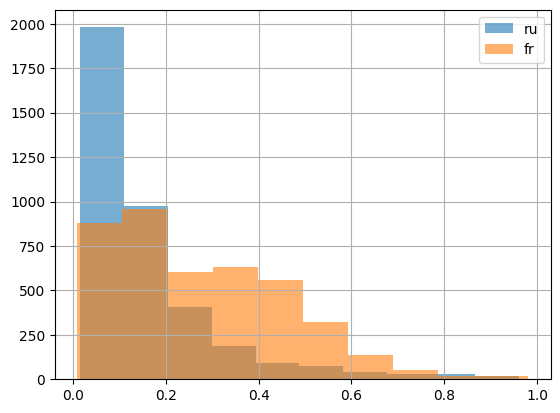

In [13]:
import matplotlib.pyplot as plt

# get the top-1 answer for every pattern-tuple pair
ru_max = new_ru.groupby(['pattern', 'sub_label', 'obj_label'])['pred_score'].max()
fr_max = new_fr.groupby(['pattern', 'sub_label', 'obj_label'])['pred_score'].max()

# get the distribution of model scores
ru_max.hist(alpha=0.6, label='ru')
fr_max.hist(alpha=0.6, label='fr')
plt.legend()
plt.show()

###Какие объекты мы восстанавливаем хорошо, а какие плохо?

In [19]:
# города, которые мы чаще всего угадывали, и доля угаданных случаев, от всех, где этот город является объектом
new_corrects_ru_set.groupby(['obj_label'])['pred_token'].count().reset_index()\
    .merge(new_ru[~new_ru['pattern_ind'].isin(ru_bad)].groupby(['obj_label'])['pred_token'].count().reset_index(), on='obj_label', how='inner')\
    .set_index('obj_label')\
    .apply(lambda x: 1.0*x['pred_token_x']/x['pred_token_y']*5, axis=1).sort_values(ascending=False)

obj_label
Токио        1.000000
Барселона    1.000000
Киев         0.972222
Москва       0.952381
София        0.916667
Лондон       0.855019
Белград      0.854167
Стамбул      0.833333
Загреб       0.777778
Мадрид       0.750000
Рим          0.613383
Минск        0.611111
Париж        0.550000
Дамаск       0.472973
Анкара       0.388889
Пекин        0.333333
Берлин       0.315126
Милан        0.222222
dtype: float64

In [14]:
new_corrects_fr_set.groupby(['obj_label'])['pred_token'].count().reset_index()\
    .merge(new_fr[~new_fr['pattern_ind'].isin(fr_bad)].groupby(['obj_label'])['pred_token'].count().reset_index(), on='obj_label', how='inner')\
    .set_index('obj_label')\
    .apply(lambda x: 1.0*x['pred_token_x']/x['pred_token_y']*5, axis=1).sort_values(ascending=False).head(30)

obj_label
Mary         0.666667
Miami        0.666667
Chennai      0.666667
Nairobi      0.666667
Boston       0.666667
Montréal     0.666667
Sarajevo     0.600000
Sofia        0.583333
Tokyo        0.555556
Bruxelles    0.523810
Lund         0.500000
Genève       0.500000
Hassan       0.500000
Hampton      0.500000
Auckland     0.500000
Mobile       0.500000
Madison      0.500000
Nice         0.500000
Porto        0.500000
Phoenix      0.500000
Kyoto        0.500000
Pune         0.500000
Santiago     0.500000
Lyon         0.500000
Tallinn      0.500000
Tirana       0.500000
Bangalore    0.500000
Toronto      0.500000
Madrid       0.500000
Rome         0.481481
dtype: float64

На французском мы не угадали ни одного города 

### Какие субъекты дают больше всего информации?
Посмотрим в целом на топ субъектов, у которых мы угадали субъекты в наибольшей доле случаев:

In [15]:
new_corrects_ru_set.groupby(['sub_label'])['pred_token'].count().reset_index()\
    .merge(new_ru[(~new_ru['pattern_ind'].isin(ru_bad))].groupby(['sub_label'])['pred_token'].count().reset_index(), on='sub_label', how='inner')\
    .set_index('sub_label')\
    .apply(lambda x: 1.0*x['pred_token_x']/x['pred_token_y']*5, axis=1).sort_values(ascending=False).head(30)

sub_label
Сербия и Черногория                                 1.0
Киевская Русь                                       1.0
Япония                                              1.0
Испанская империя                                   1.0
Югославия                                           1.0
РСФСР                                               1.0
Каталония                                           1.0
Киево-Святошинский район                            1.0
Парижская коммуна                                   1.0
Дамаск                                              1.0
Королевство Великобритания                          1.0
Украинская держава                                  1.0
Королевство Сербия                                  1.0
Королевство Югославия                               1.0
Украинская Советская Социалистическая Республика    1.0
Украина                                             1.0
Рейхскомиссариат Московия                           1.0
Японская империя                      

In [16]:
omonyms_ru = new_ru[new_ru.apply(lambda x: x['obj_label'][0:-2] in x['sub_label'], axis=1)][['tuple_ind','sub_label','sub_uri','obj_label','obj_uri']].drop_duplicates()
omonyms_ru

,tuple_ind,sub_label,sub_uri,obj_label,obj_uri
5,1,Бродовский район,Q2599799,Броды,Q465104
45,9,Александрия,Q29943,Александрия,Q87
50,10,Коломбо,Q606287,Коломбо,Q35381
70,14,Сити-оф-Карлайл,Q1094110,Карлайл,Q192896
90,18,Дакка,Q1850485,Дакка,Q1354
...,...,...,...,...,...
3125,625,Ананд (округ),Q485683,Ананд,Q1798750
3145,629,Триполитания,Q192435,Триполи,Q3579
3150,630,Римская республика,Q17167,Рим,Q220
3180,636,Сити-оф-Лидс,Q774015,Лидс,Q39121


In [17]:
tmp = new_ru.merge(omonyms_ru, on='tuple_ind', suffixes=(None, '_y'))\
            .groupby(['pattern_ind', 'tuple_ind', 'pattern', 'sub_label', 'obj_label'])['pred_token'].apply(list).reset_index()\
            .apply(lambda x: any(y==x['obj_label'] for y in x['pred_token']), axis=1)
tmp.sum()/tmp.count()

0.08841463414634146

In [18]:
omonyms_fr = new_fr[new_fr.apply(lambda x: x['obj_label'][0:-2] in x['sub_label'], axis=1)][['tuple_ind','sub_label','sub_uri','obj_label','obj_uri']].drop_duplicates()
omonyms_fr

,tuple_ind,sub_label,sub_uri,obj_label,obj_uri
45,9,Alexandrie,Q29943,Alexandrie,Q87
50,10,Colombo,Q606287,Colombo,Q35381
70,14,cité de Carlisle,Q1094110,Carlisle,Q192896
130,26,comté d'Athens,Q485588,Athens,Q755420
155,31,Aberdeenshire,Q189912,Aberdeen,Q36405
...,...,...,...,...,...
3385,677,Minsk,Q192959,Minsk,Q2280
3390,678,district d'Anand,Q485683,Anand,Q1798750
3410,682,Tripolitaine,Q192435,Tripoli,Q3579
3450,690,cité de Leeds,Q774015,Leeds,Q39121


In [19]:
tmp2 = new_fr.merge(omonyms_fr, on='tuple_ind', suffixes=(None, '_y'))\
            .groupby(['pattern_ind', 'tuple_ind', 'pattern', 'sub_label', 'obj_label'])['pred_token'].apply(list).reset_index()\
            .apply(lambda x: any(y==x['obj_label'] for y in x['pred_token']), axis=1)
tmp2.sum()/tmp2.count()

0.14227642276422764

In [21]:
a = new_ru[['sub_label', 'obj_label']].drop_duplicates().groupby('sub_label')['obj_label'].apply(list).reset_index()
omonyms2_ru = a[a['obj_label'].apply(len) > 1]
omonyms2_ru

,sub_label,obj_label
0,Аббасидский халифат,"[Дамаск, Багдад]"
7,Австро-Венгрия,"[Вена, Будапешт]"
168,Европейский союз,"[Страсбург, Брюссель]"
219,Канада,"[Монреаль, Оттава]"
244,Китайская Республика,"[Тайбэй, Нанкин]"
249,Колорадо,"[Денвер, Колумбус]"
254,Конфедеративные Штаты Америки,"[Монтгомери, Ричмонд]"
257,Королевство Англия,"[Уинчестер, Вестминстер, Лондон]"
270,Королевство Италия,"[Флоренция, Турин, Рим]"
277,Королевство Сицилия,"[Неаполь, Палермо]"


In [22]:
tmp = new_ru.merge(omonyms2_ru, on='sub_label', suffixes=(None, '_y'))\
            .groupby(['pattern_ind', 'tuple_ind', 'pattern', 'sub_label', 'obj_label'])['pred_token'].apply(list).reset_index()\
            .apply(lambda x: any(y==x['obj_label'] for y in x['pred_token']), axis=1)
tmp.sum()/tmp.count()

0.08854166666666667

In [23]:
a2 = new_fr[['sub_label', 'obj_label']].drop_duplicates().groupby('sub_label')['obj_label'].apply(list).reset_index()
omonyms2_fr = a2[a2['obj_label'].apply(len) > 1]
omonyms2_fr

,sub_label,obj_label
34,Autriche-Hongrie,"[Vienne, Budapest]"
111,Empire romain,"[Constantinople, Rome]"
402,Union européenne,"[Strasbourg, Bruxelles]"
437,califat abbasside,"[Damas, Bagdad]"
643,royaume d'Angleterre,"[Winchester, Westminster, Londres]"
647,royaume d'Italie,"[Florence, Turin, Rome]"
662,royaume de Sicile,"[Naples, Palerme]"
682,États confédérés d'Amérique,"[Montgomery, Richmond]"


In [24]:
tmp2 = new_fr.merge(omonyms2_fr, on='sub_label', suffixes=(None, '_y'))\
            .groupby(['pattern_ind', 'tuple_ind', 'pattern', 'sub_label', 'obj_label'])['pred_token'].apply(list).reset_index()\
            .apply(lambda x: any(y==x['obj_label'] for y in x['pred_token']), axis=1)
tmp2.sum()/tmp2.count()

0.16666666666666666

### Сравнение языков

In [25]:
new_corrects_ru_set.loc[8358, ['sub_label', 'obj_label', 'pred_token']]

sub_label                    Римская республика
obj_label                                   Рим
pred_token    [Рим, Италия, Москва, Roma, Rome]
Name: 8358, dtype: object

In [26]:
tt = new_ru.groupby(['pattern_ind', 'lineid', 'pattern', 'sub_label', 'obj_label'], as_index=True)['pred_token'].apply(list).reset_index()
tt['res'] = tt.apply(lambda x: any(y==x['obj_label'] for y in x['pred_token']), axis=1)
tuples_rate_ru = tt.groupby(['lineid', 'sub_label', 'obj_label']).apply(lambda x: sum(x['res'])).reset_index()

In [27]:
tt2 = new_fr.groupby(['pattern_ind', 'lineid', 'pattern', 'sub_label', 'obj_label'], as_index=True)['pred_token'].apply(list).reset_index()
tt2['res'] = tt2.apply(lambda x: any(y==x['obj_label'] for y in x['pred_token']), axis=1)
tuples_rate_fr = tt2.groupby(['lineid', 'sub_label', 'obj_label']).apply(lambda x: sum(x['res'])).reset_index()

In [28]:
b = tuples_rate_ru.merge(tuples_rate_fr, on=['lineid'])
b

,lineid,sub_label_x,obj_label_x,0_x,sub_label_y,obj_label_y,0_y
0,0,Азербайджан,Баку,0,Azerbaïdjan,Bakou,0
1,2,Кук,Чикаго,0,comté de Cook,Chicago,0
2,3,Форт-Бенд,Ричмонд,0,comté de Fort Bend,Richmond,0
3,4,Кейюга,Оберн,0,comté de Cayuga,Auburn,0
4,6,Гранд-Эст,Страсбург,0,Grand Est,Strasbourg,0
...,...,...,...,...,...,...,...
634,698,Северо-Восточный Линкольншир,Гримсби,0,North East Lincolnshire,Grimsby,0
635,699,Валенсия,Валенсия,0,province de Valence,Valence,0
636,700,Типикэну,Лафейетт,0,comté de Tippecanoe,Lafayette,0
637,701,Мазовецкое воеводство,Варшава,0,voïvodie de Mazovie,Varsovie,0


<Axes: xlabel='None-0_y', ylabel='0_x'>

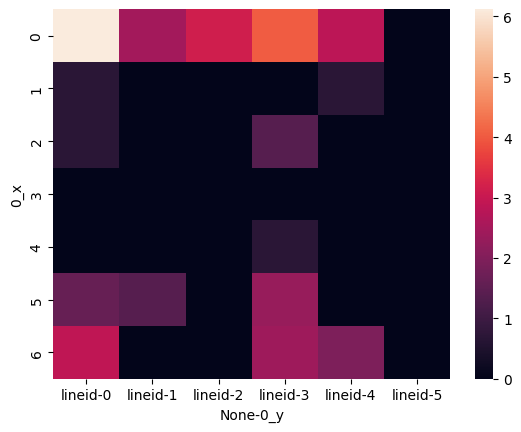

In [29]:
from math import log
import seaborn as sns

sns.heatmap(b.groupby(['0_x', '0_y'])['lineid'].count().apply(log).reset_index().pivot(index=['0_x'], columns=['0_y']).fillna(0))